In [182]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2

import gym 
import torch

env = gym.make('LunarLander-v2')

batch = []
sample_idx = 0
for i in range(10):

    obs = env.reset()
    done = False

    while not done:
        action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
        frame = env.render(mode='rgb_array')
        
        batch.append(obs)
        cv2.imwrite(f'data/dev/{sample_idx}.png', frame)
        sample_idx += 1
        
env.close()
batch = np.array(batch)

In [183]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

tsfm = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

data_dir = 'data/'
dataset = datasets.ImageFolder(data_dir, tsfm)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
len(dataset.imgs), len(dataloader)

(837, 27)

torch.Size([32, 3, 64, 64])


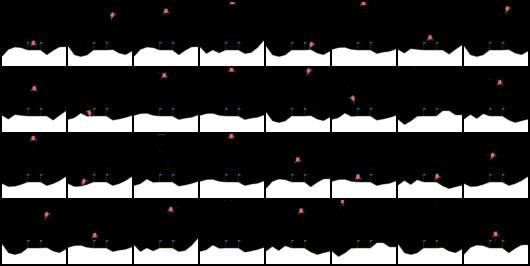

In [200]:
from IPython.display import Image
from IPython.core.display import Image, display

import torchvision
from torchvision.utils import save_image
    
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')
print(fixed_x.shape)
Image('real_image.png')

In [211]:
# https://github.com/sksq96/pytorch-vae/blob/master/vae.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            # Input: (3, 64, 64)
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten(),
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [212]:
from torch.optim import Adam
from torchsummary import summary
image_channels = fixed_x.size(1)
vae = VAE(image_channels=image_channels, h_dim=1024)
opt = Adam(vae.parameters())

summary(vae, (image_channels, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 31, 31]           1,568
              ReLU-2           [-1, 32, 31, 31]               0
            Conv2d-3           [-1, 64, 14, 14]          32,832
              ReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5            [-1, 128, 6, 6]         131,200
              ReLU-6            [-1, 128, 6, 6]               0
            Conv2d-7            [-1, 256, 2, 2]         524,544
              ReLU-8            [-1, 256, 2, 2]               0
           Flatten-9                 [-1, 1024]               0
           Linear-10                   [-1, 32]          32,800
           Linear-11                   [-1, 32]          32,800
           Linear-12                 [-1, 1024]          33,792
        UnFlatten-13           [-1, 1024, 1, 1]               0
  ConvTranspose2d-14            [-1, 12

In [213]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

In [214]:
losses = []
for i in range(20):
    
    for idx, (images, _) in enumerate(dataloader):
        opt.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss, bce, kld = loss_fn(recon_images, images, logvar, mu)
        loss.backward()
        opt.step()
    
    print(f"Epoch {i}: {loss}")

C:\Users\notes\Anaconda3\envs\mbrl\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: 14762.2705078125
Epoch 1: 11091.5087890625
Epoch 2: 4867.01416015625
Epoch 3: 4260.46435546875
Epoch 4: 3958.37939453125
Epoch 5: 4362.958984375
Epoch 6: 3660.311279296875
Epoch 7: 2130.94482421875
Epoch 8: 2426.016357421875
Epoch 9: 2152.623779296875
Epoch 10: 1780.0408935546875
Epoch 11: 1391.584228515625
Epoch 12: 1784.542724609375
Epoch 13: 1615.1602783203125
Epoch 14: 1701.7320556640625
Epoch 15: 1520.2293701171875
Epoch 16: 1780.2469482421875
Epoch 17: 1488.271240234375
Epoch 18: 1679.8656005859375
Epoch 19: 1568.4677734375


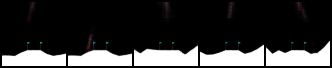

In [215]:
save_image(recon_images, 'recon_image.png')
Image('recon_image.png')

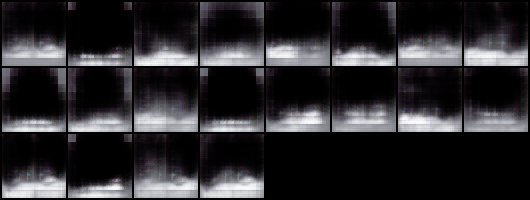

In [216]:
from scipy.stats import norm

sample_latent = torch.from_numpy(norm.rvs(size=(20,32)).astype(np.float32))
samples = vae.decode(sample_latent)

save_image(samples, 'sampled_image.png')
Image('sampled_image.png')